In [2]:
#Questions and their answers

#Q1
#Do we include correlations between target variables? or just between features and target variables?
#Just between features and target variables

#Q2
#Do we do this for all numerical features? That's a ton of histograms
#Yes

#Q3
#Search box plot and get visualization
#x-axis: categories, y-axis: target value
#use seaborn catplot
#for skewed data, need to use a non-linear transformation on the data

#Q7/8
#Can we remove columns at this point?
#Yes. Just include a justification why we need to remove them

#Do we normalize the target variables?
#No
#Do we remove the other target variables from "data inspection" from the dataset?
#Yes

#Q9
#What to do about Nan features? Set to 0? Set to column mean? Remove example entirely?
#We can set to 0, this is valid

#How many features should we take?
#For now, use all of them. When we get our "optimal model", we can go back and fine tune the features. We need
#to numerically support why we select some feature over others (threshdolding) - show performance using different
#numbers of features selected. Maybe plot average validation RMSE vs. number of features selected for each dataset?

#Can we use just one of the two given feature selection methods?
#Do this analysis later.

#Q11
#Just report the best hyperparameters. "Explain how they can be computed" is misleading. We just need to talk about
#our process for optimizing hyperparameters.

#Q12
#Try with scaled (normalized) data and unscaled. Then try with regularization and without regularization. Regularization
#should have a larger effect on unscaled data, since it punished the larger values a lot more

#Q27
#Performances should follow the specific questions. We just need to put the answer to that one question there.

In [1]:
#Q1a


#Targets: suicide_no and suicide/100k
#Pearson is linear correlation
#number of suicides highly correlated with population. For a fixed suicide rate, a higher population will result in a higher number of suicides
#suicide rate slightly correlated with number of suicides. suicide_rate = suicide_no/pop. Strength of the correlation depends on pop


#Q2a

import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

suic_df = pd.read_csv("archive/master.csv")
suic_profile = ProfileReport(suic_df, title="Suicide Profiling Report")
suic_profile.to_widgets()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
#Q1b

#Targets: casual, registered, cnt

#High correlation between registered and cnt. This implies that most users are registered 
#Medium negative correlation between "workingday" and casual. Workingday is 1 if the day is a holiday/weekend, 0 o.w.
    #Implies that casual users tend to do most of their biking during the weekened/holidays - makes sense
    #since they're probably doing it as a chill activity, rather than a daily workout or a means to get to work/school

#All three have medium-high correlations with temp/atemp. People like biking in warmer weather
#Registered/cnt have medium-high correlations with year - most registered bikers were biking in 2012.
    # could imply that people have been using rental bikes more in more, so there were just more users in 2012 than 2011.

bike_df = pd.read_csv("Bike-Sharing-Dataset/day.csv")
bike_profile = ProfileReport(bike_df, title="Bike Sharing Profiling Report")
bike_profile.to_widgets()

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
#Q1c

#Target variables: utime (transcoding time)

#Transcoding time high correlated with total codec allocated memory for transcoding, and medium-high correlation
#transcoding width/height. It takes longer to transcode larger sequences, which also means that it takes more memory to
#transcode the sequence



vid_df = pd.read_csv("online_video_dataset/transcoding_mesurment.tsv", delimiter='\t')
vid_profile = ProfileReport(vid_df, title="Video Transcoding Profiling Report")
vid_profile.to_widgets()

Summarize dataset:   0%|          | 0/35 [00:00<?, ?it/s]

C:\Users\Zoe\anaconda3\lib\site-packages\pandas_profiling\model\correlations.py:192: RuntimeWarning: invalid value encountered in greater_equal
  bool_index = abs(correlation_matrix.values) >= threshold


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Suicide Histograms


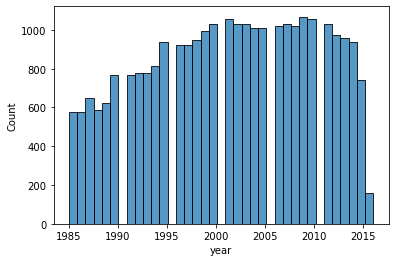

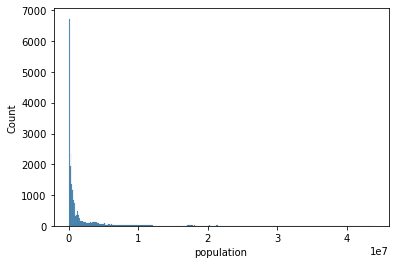

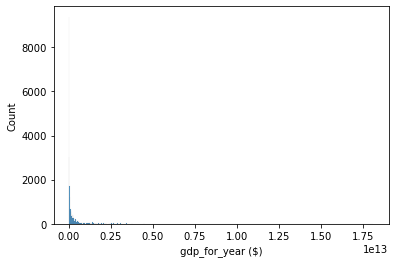

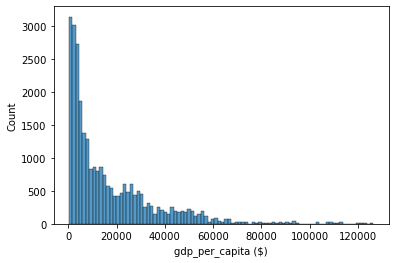

Bike Histograms


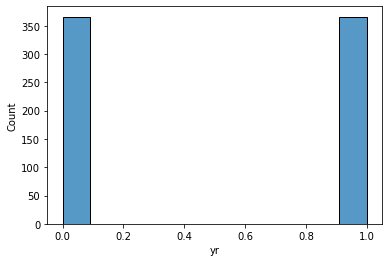

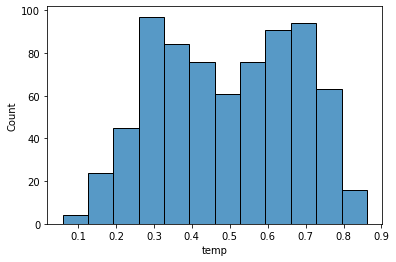

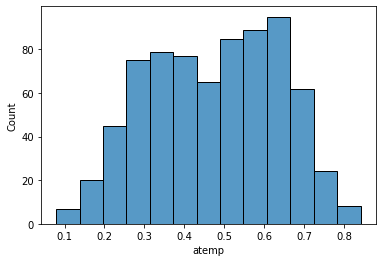

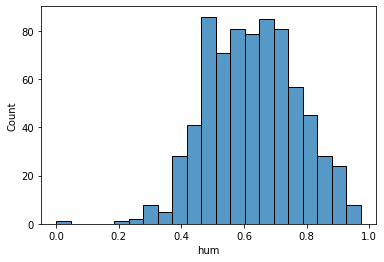

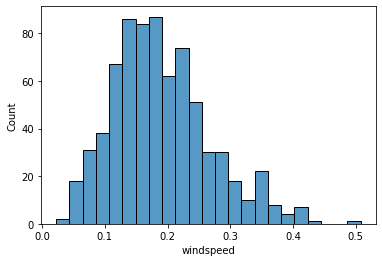

Video Histograms


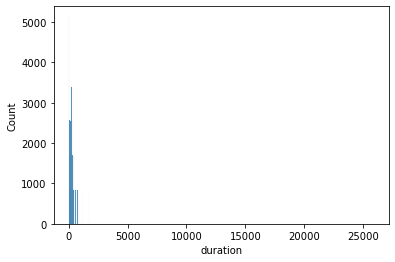

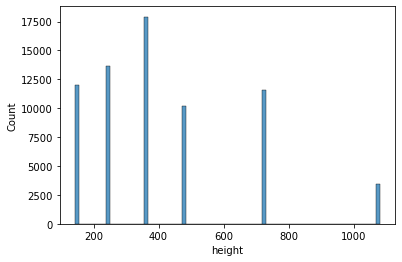

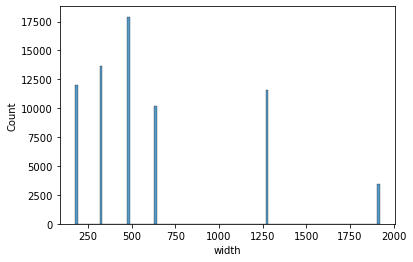

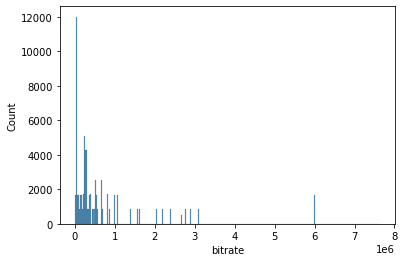

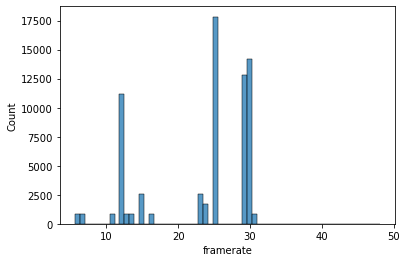

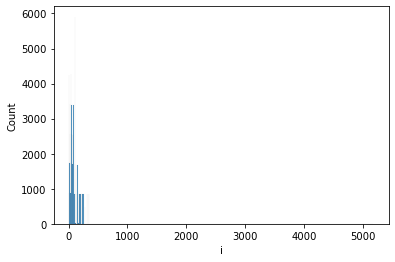

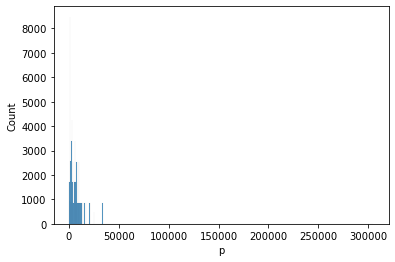

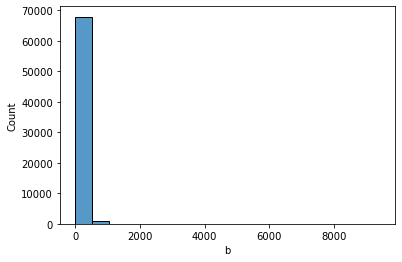

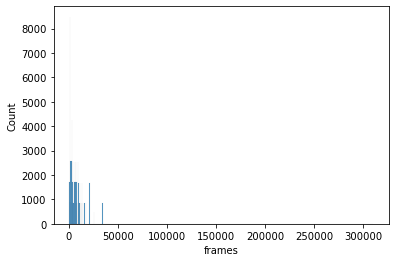

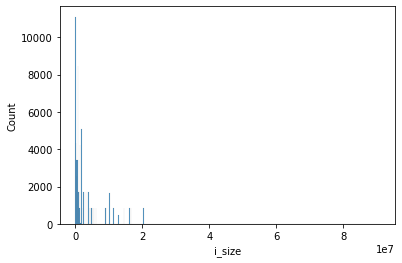

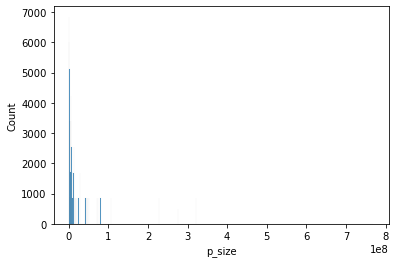

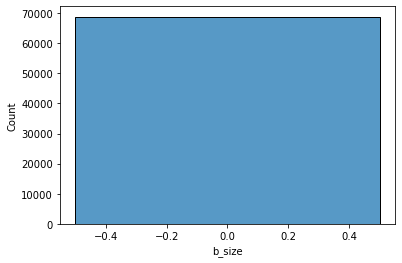

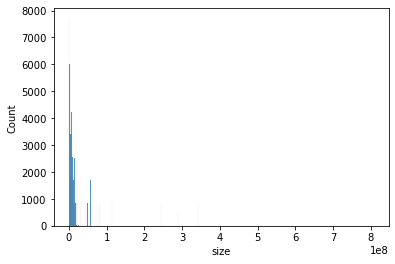

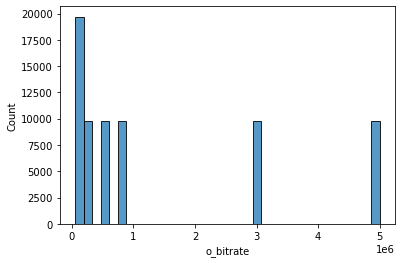

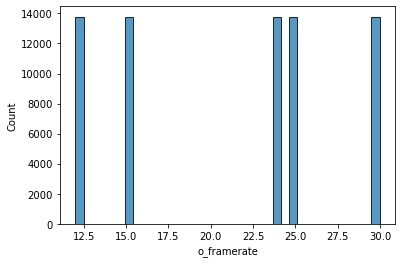

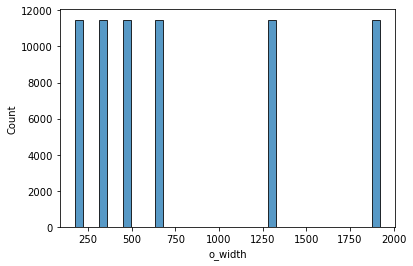

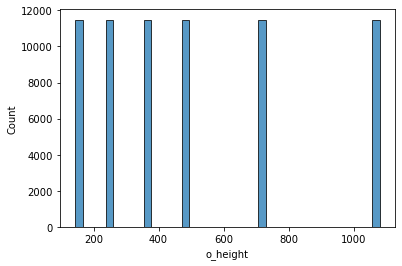

In [33]:
#Q2
import seaborn
suic_df_hist = suic_df.copy()
suic_df_hist[' gdp_for_year ($) ']=suic_df_hist[' gdp_for_year ($) '].str.replace(',','').astype(float)
suic_num_cols = ['year', 'population', ' gdp_for_year ($) ','gdp_per_capita ($)']
print("Suicide Histograms")
for col in suic_num_cols:
    seaborn.histplot(data=suic_df_hist, x=col)
    plt.show()
    
bike_num_cols = ['yr', 'temp', 'atemp', 'hum', 
              'windspeed']
print("Bike Histograms")
for col in bike_num_cols:
    seaborn.histplot(data=bike_df, x=col)
    plt.show()
    
vid_num_cols =['duration', 'height','width','bitrate','framerate',
              'i','p','b','frames','i_size','p_size','b_size',
              'size', 'o_bitrate','o_framerate','o_width','o_height']
print("Video Histograms")
for col in vid_num_cols:
    seaborn.histplot(data=vid_df, x=col)
    plt.show()
    


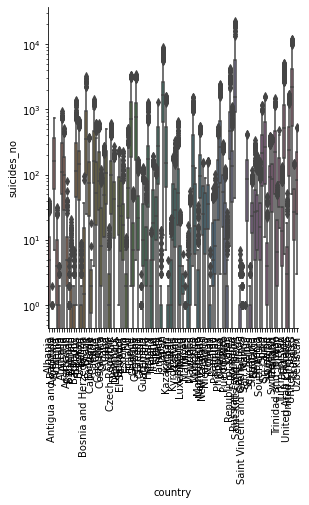

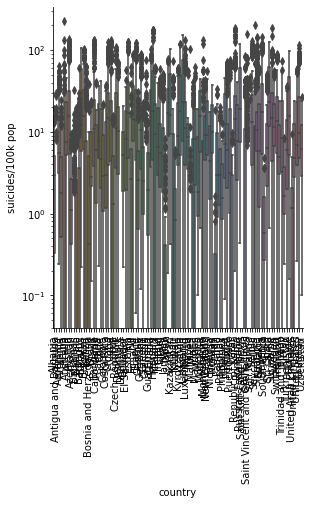

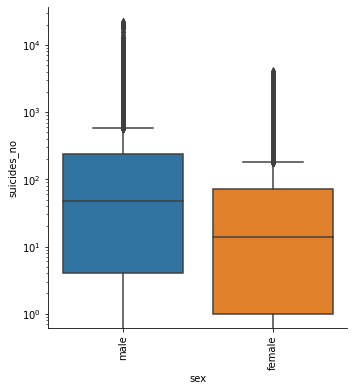

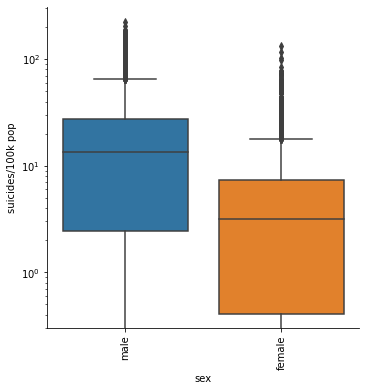

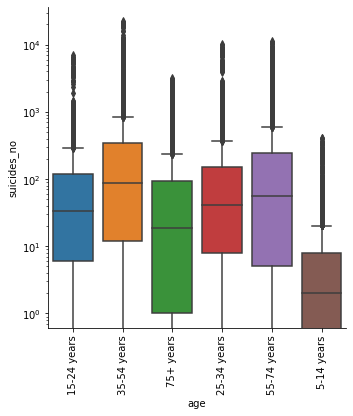

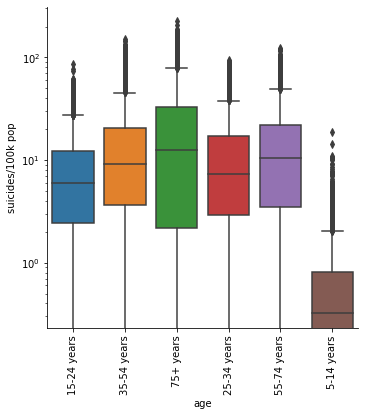

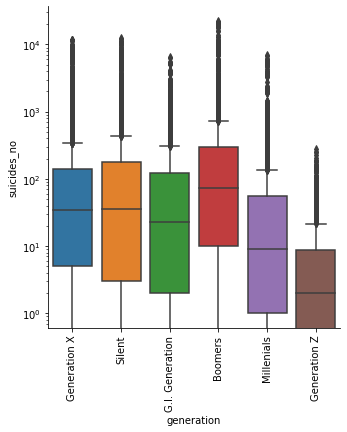

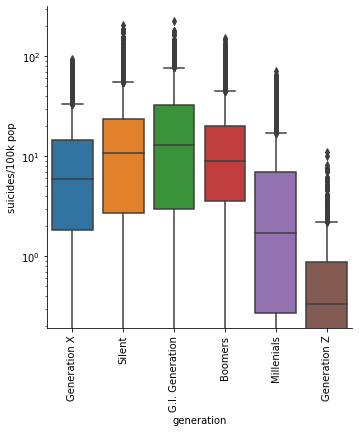

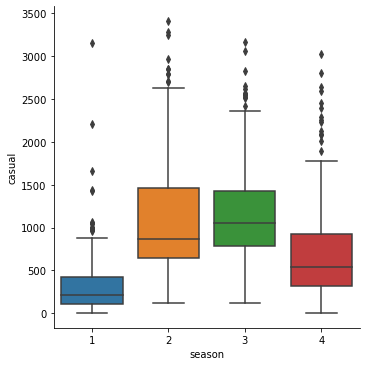

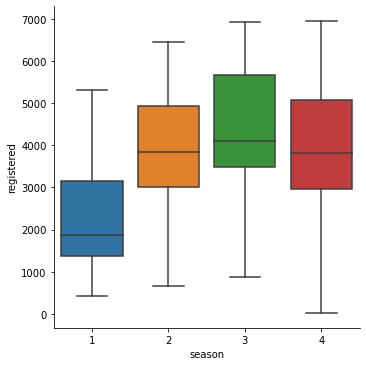

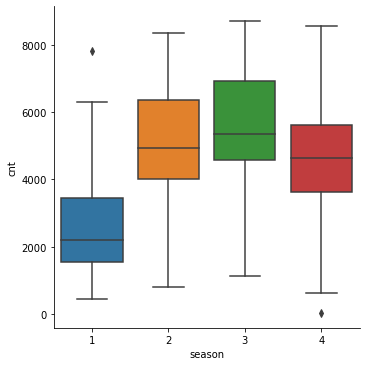

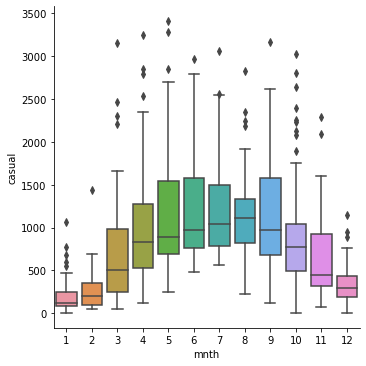

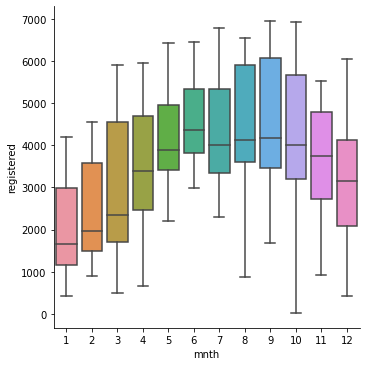

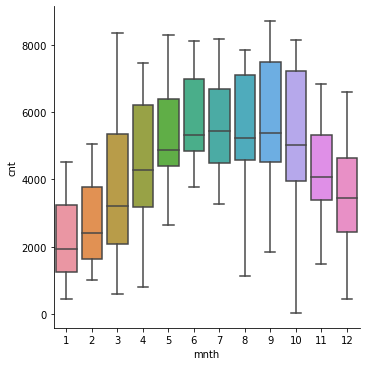

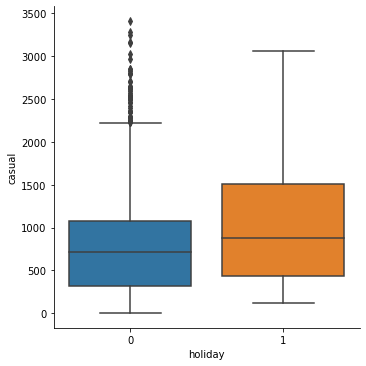

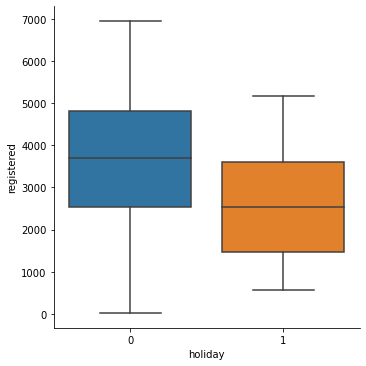

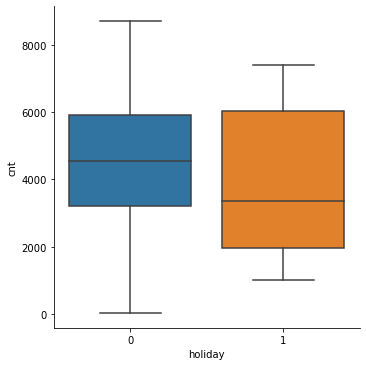

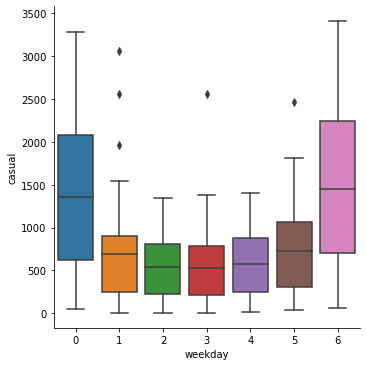

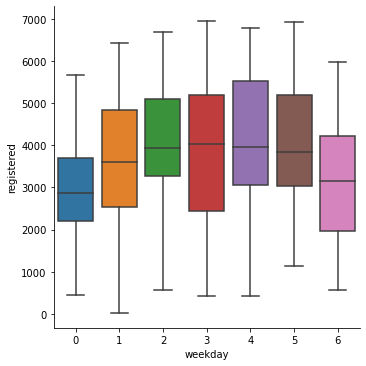

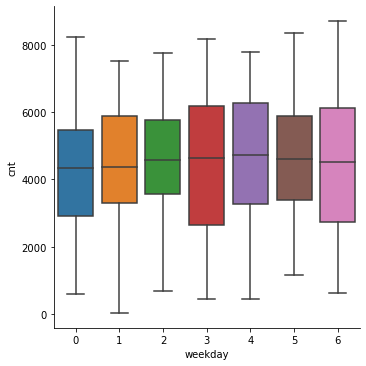

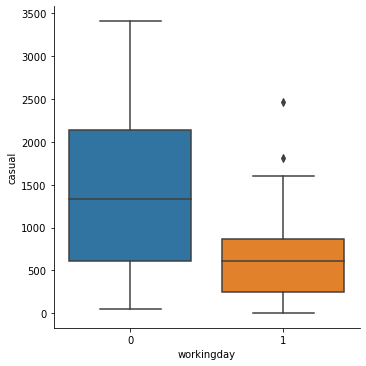

In [50]:
#Q1b

#Targets: casual, registered, cnt

#High correlation between registered and cnt. This implies that most users are registered 
#Medium negative correlation between "workingday" and casual. Workingday is 1 if the day is a holiday/weekend, 0 o.w.
    #Implies that casual users tend to do most of their biking during the weekened/holidays - makes sense
    #since they're probably doing it as a chill activity, rather than a daily workout or a means to get to work/school

#All three have medium-high correlations with temp/atemp. People like biking in warmer weather
#Registered/cnt have medium-high correlations with year - most registered bikers were biking in 2012.
    # could imply that people have been using rental bikes more and more, so there were just more users in 2012 than 2011.

bike_df = pd.read_csv("Bike-Sharing-Dataset/day.csv")
bike_profile = ProfileReport(bike_df, title="Bike Sharing Profiling Report")
bike_profile.to_widgets()

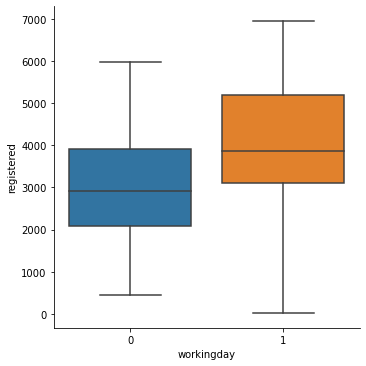

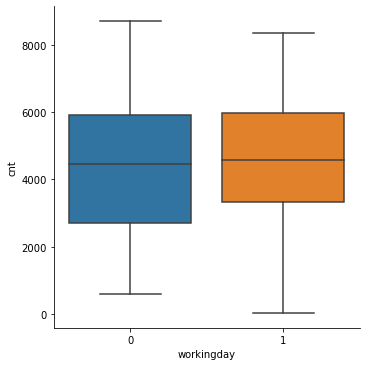

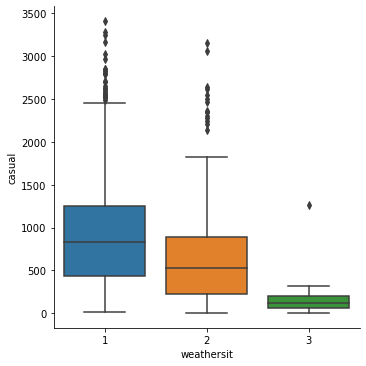

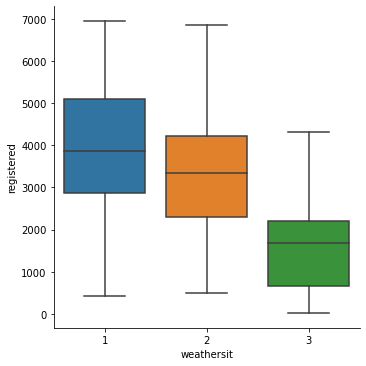

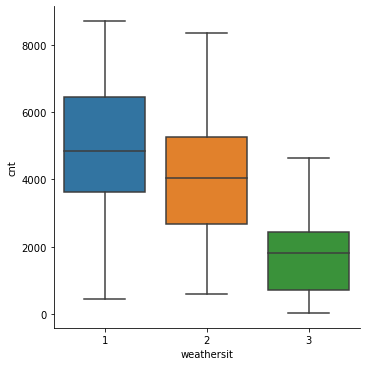

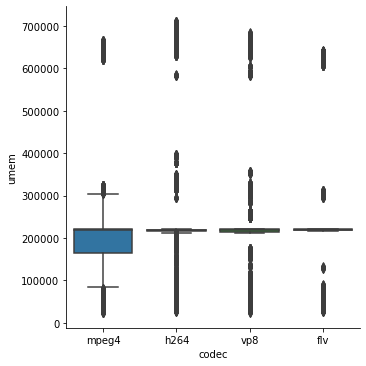

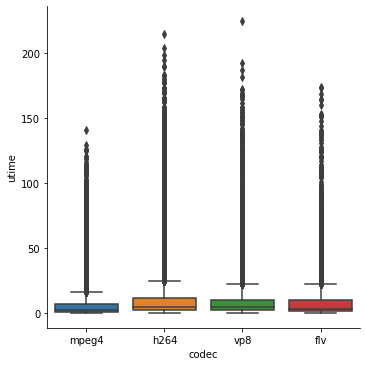

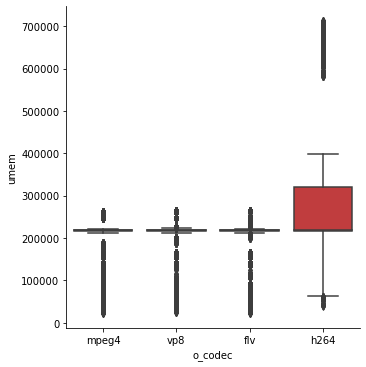

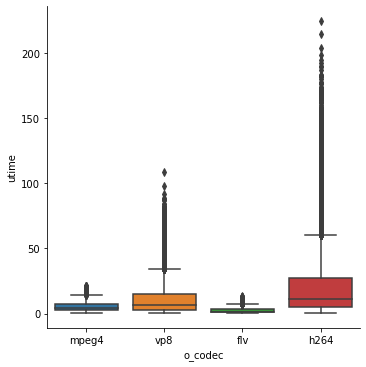

In [5]:
#Q3 
suic_cat_cols = ['country', 'sex', 'age','generation']
suic_targets = ['suicides_no', 'suicides/100k pop']
for col in suic_cat_cols:
    for target in suic_targets:
        g = seaborn.catplot(data=suic_df_hist, x=col,y=target,kind='box')
        g.fig.get_axes()[0].set_yscale('log')
        plt.xticks(rotation='vertical')
        plt.show()
        

bike_cat_cols = ['season','mnth','holiday','weekday','workingday',
                 'weathersit']
bike_targets = ['casual','registered','cnt']
for col in bike_cat_cols:
    for target in bike_targets:
        seaborn.catplot(data=bike_df, x=col,y=target,kind='box')
        plt.show()

vid_cat_cols = ['codec','o_codec']
vid_targets = ['umem','utime']
for col in vid_cat_cols:
    for target in vid_targets:
        seaborn.catplot(data=vid_df, x=col,y=target,kind='box')
        plt.show()
        
        
        

In [ ]:
#Q4 
import matplotlib.pyplot as plt
trunc_bike_df = bike_df.truncate(before=220,after=310)
trunc_bike_df.plot(kind='bar',x='dteday',y='cnt', 
                   title='Count Number per Day',xlabel ='Date',
                  ylabel = 'Count',figsize = (18,6), legend = False)

plt.show()

#I picked some random indexes into the graph - not sure is this is the best one
#Looks like ridership goes way down on weekends, esp. Saturdays

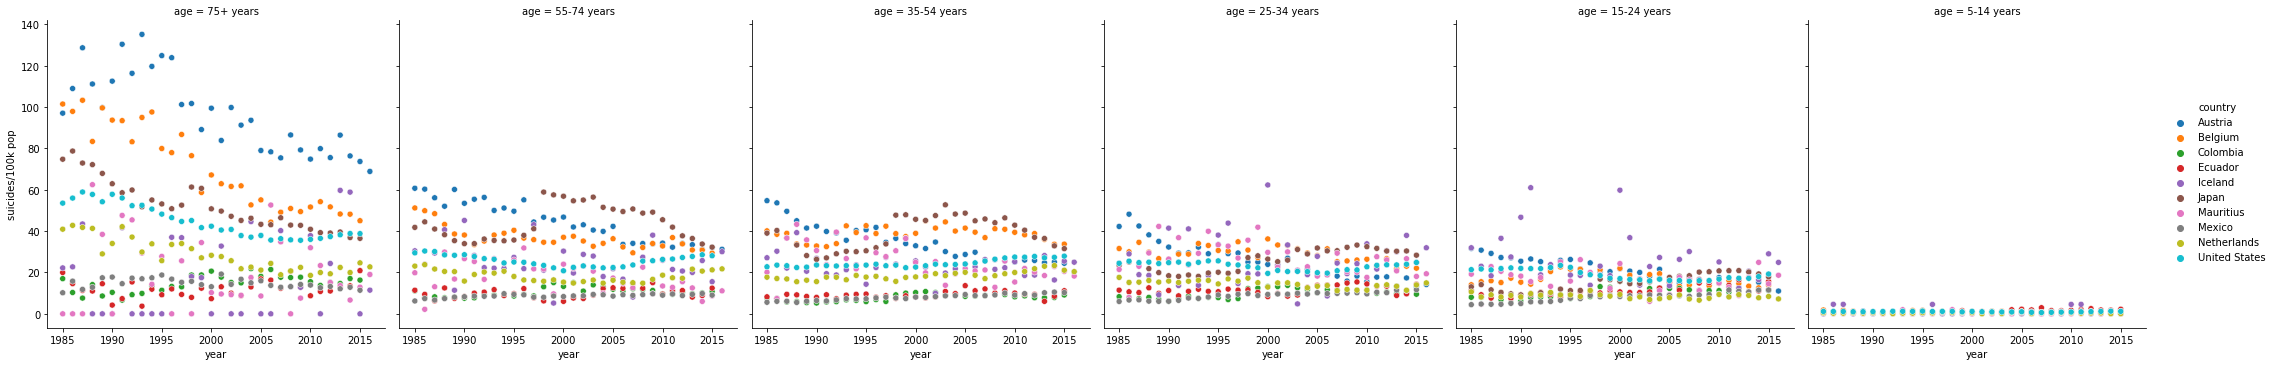

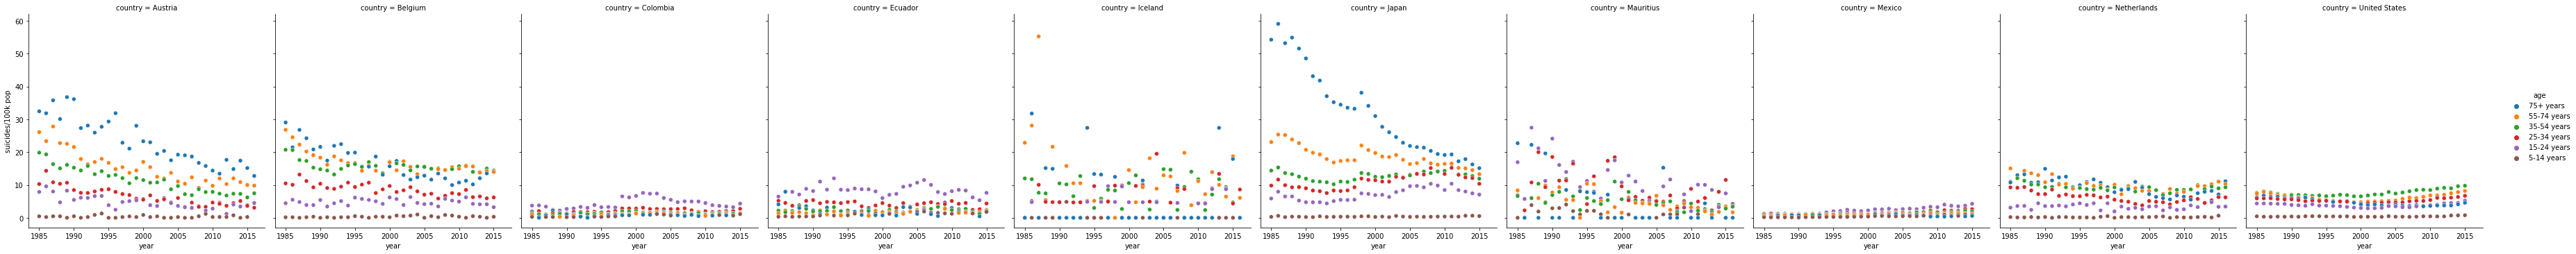

In [7]:
#Q5
import seaborn

top_countries = suic_df["country"].value_counts()[:10].index.tolist()
filtered_suic_df = suic_df[suic_df.country.isin(top_countries)]
male_df = filtered_suic_df[filtered_suic_df["sex"]=="male"]
female_df = filtered_suic_df[filtered_suic_df["sex"]=="female"]

#currently using two different ways of showing the data for male and female subsets
#should defintely pick just one (or a more granular one)

seaborn.relplot(data=male_df, x="year", y="suicides/100k pop", hue="country",col="age")
seaborn.relplot(data=female_df, x="year", y="suicides/100k pop", hue="age",col="country")

[214.481 203.781 224.574]


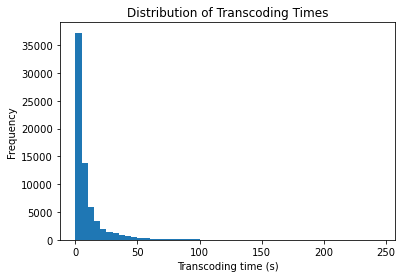

Mean: 9.996354820888579 s
Median: 4.408 s


In [195]:
#Q6
import matplotlib.pyplot as plt


#Most transcodings take very little time: between 0s and 10s

utime_vals = vid_df['utime'].to_numpy()
print(utime_vals[utime_vals > 200])
plt.hist(utime_vals, bins=np.arange(0, 250, 5))
plt.title("Distribution of Transcoding Times")
plt.xlabel("Transcoding time (s)")
plt.ylabel("Frequency")
plt.show()

print("Mean: {} s".format(np.mean(utime_vals)))
print("Median: {} s".format(np.median(utime_vals)))

In [153]:
#Q7, Q8

#What information does one-hot encoding discard?
#With numerical encoding: e.g. {1, 2, ... 12} for {Jan, Feb, ... Dec} we preserve distance information in the euclidean
#space between the months. We know that Jan and Mar surround Feb (not necessarily in that order).For encoding with one-hot encoding we 
#lose this information, and all months appear to be equidistant to each other. For some applications this doesn't matter,
#but it's definitely something that needs to be considered. For the quality feature vector {Poor, Fair, Typical, Good, Excellent} 
#if we proceed with one-hot encoding we also lose that distance information, so Excellent would be equidistant to
#Good and Poor, and we lose our sense of scale.

#What assumption should hold strongly if we perform the scalar encoding instead?
#Our features are on a scale, and are not equidistant to each other. Larger features are "more important"

#Convert countries to continents:
#https://stackoverflow.com/questions/55910004/get-continent-name-from-country-using-pycountry

from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler


##### Suicide Dataset #####
def country_to_continent(country_name):
    try:
        item = country_alpha2_to_continent_code(country_name_to_country_alpha2(country_name))
        
    #Handle countries not in pycountry
    except KeyError:
        if (country_name == "Republic of Korea"):
            item = 'AS'
        elif (country_name == "Saint Vincent and Grenadines"):
            item = 'SA'
        else:
            print(country_name)
    return item


suic_df_preprocessed = suic_df.copy()

#Convert countries to a continent code
suic_df_preprocessed["country"] = suic_df_preprocessed["country"].apply(lambda x: country_to_continent(x))

#Remove country-year feature. Also remove target variables
suic_df_preprocessed = suic_df_preprocessed.drop(['country-year', 'suicides/100k pop', 'suicides_no'], axis=1)

#Necessary because values with commas can't be converted to floats
suic_df_preprocessed[' gdp_for_year ($) ']=suic_df_preprocessed[' gdp_for_year ($) '].str.replace(',','')

preprocess_suic = make_column_transformer(
    (StandardScaler(),['year', 'population', 'HDI for year', ' gdp_for_year ($) ', 'gdp_per_capita ($)']),
    (OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore'), ['country', 'sex', 'age', 'generation']),
    remainder='passthrough'
)

suic_df_preprocessed = preprocess_suic.fit_transform(suic_df_preprocessed)
#print(suic_df_preprocessed)



##### Bike Dataset #####
bike_df_preprocessed = bike_df.copy()

#Remove seemingly useless columns and target variables
#also remove atemp, since it's so similar to temp and does not reveal any new information (correlation with temp is 1:1)
#Should we one-hot the season and month data columns? They are currently numerical, but that might not make the most 
#sense

bike_df_preprocessed = bike_df_preprocessed.drop(['instant', 'dteday', 'cnt', 'casual', 'registered', 'atemp'], axis=1)

preprocess_bike = make_column_transformer(
    (StandardScaler(), bike_df_preprocessed.columns.drop(['season', 'mnth'])),
    (OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore'), ['season', 'mnth']),
    remainder='passthrough'
)

bike_df_preprocessed = preprocess_bike.fit_transform(bike_df_preprocessed)
#print(bike_df_preprocessed)



##### Video Dataset #####

vid_df_preprocessed = vid_df.copy()

#Remove ID column. Carries no important information. Also remove target
vid_df_preprocessed = vid_df_preprocessed.drop(['id', 'utime', 'umem'], axis=1)

#Preprocess all but utime
preprocess_vid = make_column_transformer(
    (StandardScaler(), vid_df_preprocessed.columns.drop(['codec', 'o_codec'])),
    (OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore'), ['codec', 'o_codec']),
    remainder='passthrough'
)

vid_df_preprocessed = preprocess_vid.fit_transform(vid_df_preprocessed)
#print(vid_df_preprocessed)

In [10]:
#Q9

from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest


#Currently using ~3/4 of all features from mutual_info_regression - I have no idea how many we should be using

fraction_of_total = 1
num_feat_suic = int(np.floor(fraction_of_total * suic_df_preprocessed.shape[1]))
score_func_suic = mutual_info_regression
#score_func_suic = f_regression

num_feat_bike = int(np.floor(fraction_of_total * bike_df_preprocessed.shape[1]))
score_func_bike = mutual_info_regression
#score_func_bike = f_regression

num_feat_vid = int(np.floor(fraction_of_total * vid_df_preprocessed.shape[1]))
score_func_vid = mutual_info_regression
#score_func_vid = f_regression


fs_suic = SelectKBest(score_func=score_func_suic, k=num_feat_suic)
fs_bike = SelectKBest(score_func=score_func_bike, k=num_feat_bike)
fs_vid = SelectKBest(score_func=score_func_vid, k=num_feat_vid)

labels_suic = suic_df['suicides/100k pop']
labels_bike = bike_df['cnt']
labels_vid = vid_df['utime']

#Set nan to 0. Can change later
df_nans = np.isnan(suic_df_preprocessed)
suic_df_preprocessed[df_nans] = 0

#Pick top k features
suic_data_ready = fs_suic.fit_transform(suic_df_preprocessed, labels_suic)
bike_data_ready = fs_bike.fit_transform(bike_df_preprocessed, labels_bike)
vid_data_ready = fs_vid.fit_transform(vid_df_preprocessed, labels_vid)


In [164]:
#From project 1
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs 
            
    def fit_LGB(self, X, y, cv=3, n_jobs=3, feature_name=None, categorical_feature=None, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y, feature_name=feature_name, categorical_feature=categorical_feature, verbose=verbose)
            self.grid_searches[key] = gs  
    
    def fit_Cat(self, X, y, cv=3, n_jobs=3, cat_features=None, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y, cat_features=cat_features, verbose=verbose)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params, mean_train_score):
            
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
                 'mean_train_score': mean_train_score
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            mean_train_scores = self.grid_searches[k].cv_results_['mean_train_score']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s, t in zip(params,all_scores,mean_train_scores):
                rows.append((row(k, s, p, t)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score', 'mean_train_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]
    

In [154]:
#Neural Networks

#Q17
#The FC network is capable of learning non-linearities in the data, since non-linear inner layer activation functions such as relu/tanh
#can be applied. Linear regression is a linear classifier, and as such cannot do this.

#Q18
#Use gridsearch to get params. Not working great results right now on suicide dataset, maybe features aren't great?

#Q19
#We don't want to include an activation function, since this is a regression problem that should more closely
#match the linear/polynomial regression we did earlier. We also don't need our output to match any particular distribution
#since we do not have any standard scaling for our target variables

#Q20
#Increasing the number of layers will increase the number of network parameters to train, making it a lot more difficult to train
#the network (takes longer) and more likely to overfit our training data.



from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

nn_classifier = MLPRegressor(activation="relu", validation_fraction=0, max_iter=500)

#Try varying depths, # of neurons, regression strength
#Changes depending on the dataset we're looking at
params = {
    'hidden_layer_sizes': [(5, 5), (10, 10), (10, 10, 10)],
    'alpha': [0.01, 0.001, 0.0001]
}

models_in = {
    'MLP': nn_classifier
}

params_in = {
    'MLP': params
}

"""
grid_search = EstimatorSelectionHelper(models_in, params_in)
grid_search.fit(suic_data_ready, labels_suic, n_jobs=-1, cv=10, scoring='neg_root_mean_squared_error')
print(grid_search.score_summary(sort_by='mean_score'))



grid_search = EstimatorSelectionHelper(models_in, params_in)
grid_search.fit(bike_data_ready, labels_bike, n_jobs=-1, cv=10, scoring='neg_root_mean_squared_error')
print(grid_search.score_summary(sort_by='mean_score'))
"""


grid_search = EstimatorSelectionHelper(models_in, params_in)
grid_search.fit(vid_data_ready, labels_vid, n_jobs=-1, cv=10, scoring='neg_root_mean_squared_error')
print(grid_search.score_summary(sort_by='mean_score'))


Running GridSearchCV for MLP.
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.8min


  estimator  min_score mean_score max_score  std_score mean_train_score  \
6       MLP  -8.476887  -5.469578 -4.297901   1.310769        -3.992394   
0       MLP  -8.470128  -5.567437 -3.867153   1.318964         -4.35751   
8       MLP  -8.737842   -5.75328 -3.620619    1.75311        -2.737206   
3       MLP -11.985116  -5.940841 -3.957723    2.24097        -4.090248   
2       MLP  -9.869287  -6.074239 -3.444744   2.215972        -2.848566   
5       MLP -14.399182  -6.098335 -4.233872   2.863466        -2.795542   
1       MLP -15.874104  -6.403407 -4.026255   3.386768        -2.921594   
4       MLP -18.807669  -6.693993 -3.993539   4.298979        -3.020749   
7       MLP -68.173103 -12.240488 -3.663113  18.804128         -3.06088   

    alpha hidden_layer_sizes  
6  0.0001             (5, 5)  
0    0.01             (5, 5)  
8  0.0001       (10, 10, 10)  
3   0.001             (5, 5)  
2    0.01       (10, 10, 10)  
5   0.001       (10, 10, 10)  
1    0.01           (10, 10)  
4

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 37.6min finished


In [115]:
grid_search.score_summary(sort_by='mean_score')


LGB


,estimator,min_score,mean_score,max_score,std_score,boosting_type,learning_rate,max_depth,num_leaves,reg_alpha,reg_lambda
5,LGB,-21.676762,-16.330215,-8.380468,3.573788,gbdt,0.1,-1,150,0.01,0.001
4,LGB,-21.808691,-16.368711,-8.482943,3.620525,gbdt,0.1,-1,150,0.01,0.01
7,LGB,-21.720444,-16.370233,-8.447847,3.569064,gbdt,0.1,-1,150,0.001,0.001
6,LGB,-21.714757,-16.389719,-8.454215,3.607578,gbdt,0.1,-1,150,0.001,0.01
20,LGB,-21.590538,-16.447419,-8.809415,3.501395,gbdt,0.05,-1,150,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...
17,LGB,-22.307534,-16.879874,-8.760289,3.855191,gbdt,0.05,-1,20,0.01,0.001
19,LGB,-22.307534,-16.879875,-8.76029,3.855191,gbdt,0.05,-1,20,0.001,0.001
26,LGB,-22.214417,-16.88378,-8.815874,3.824724,gbdt,0.05,8,20,0.001,0.01
16,LGB,-22.303276,-16.886627,-8.769464,3.858866,gbdt,0.05,-1,20,0.01,0.01


In [34]:
#Linear Regression
#Q10
#Regularization serves to limit the available hypothesis space to reduce overfitting.
#Lasso regression (L1 regularization, using absolute value) and 
#Ridge regression (L2 regularization, using squares) are two options for this.
#Both penalize hypothesis "complexity" by reducing weights.
#Lasso regression is more likely to make weights zero for irrelevant features,
#while ridge regression is likely to just make weights small.

#Q11
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

unreg_classifier = LinearRegression()
l1_classifier = Lasso(max_iter=10000)
l2_classifier = Ridge(max_iter=10000)

params = {
    'alpha': [1, 0.1, 0.01]
}

models_in = {
    'Unreg': unreg_classifier,
    'Lasso': l1_classifier,
    'Ridge': l2_classifier
}

params_in = {
    'Lasso': params,
    'Ridge': params,
    'Unreg': {}
}

grid_search = EstimatorSelectionHelper(models_in, params_in)
grid_search.fit(suic_data_ready, labels_suic, n_jobs=1, cv=5)
grid_search.score_summary(sort_by='mean_score')

#Q12
#In the case without regularization, feature scaling does not matter other than in speeding up computation. 
#However, feature scaling is very important if regularization is used.
#This is due to the way that regularization penalizes features.
#We want to make sure our features are centered and operate on the same "scale",
#so that none are unfairly penalized.

#Q13
#The p values reported by some linear regression packages for different features
#give the results of the hypothesis test that the slope is zero. 
#This can be used to roughly rank the most significant features by looking
#for the ones corresponding to the lowest p values.

Running GridSearchCV for Unreg.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running GridSearchCV for Lasso.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Running GridSearchCV for Ridge.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Unreg
Lasso
Ridge


,estimator,min_score,mean_score,max_score,std_score,alpha
2,Lasso,0.278159,0.322242,0.389887,0.03722,0.1
3,Lasso,0.285272,0.318988,0.3891,0.03741,0.01
4,Ridge,0.285898,0.318343,0.38867,0.037455,1
5,Ridge,0.285914,0.318331,0.388659,0.037453,0.1
6,Ridge,0.285915,0.31833,0.388658,0.037453,0.01
0,Unreg,0.285916,0.31833,0.388658,0.037453,NaN
1,Lasso,0.200877,0.252667,0.299601,0.031964,1


In [35]:
grid_search = EstimatorSelectionHelper(models_in, params_in)
grid_search.fit(bike_data_ready, labels_bike, n_jobs=1, cv=5)
grid_search.score_summary(sort_by='mean_score')

Running GridSearchCV for Unreg.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running GridSearchCV for Lasso.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Running GridSearchCV for Ridge.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Unreg
Lasso
Ridge


,estimator,min_score,mean_score,max_score,std_score,alpha
4,Ridge,-0.699051,0.126196,0.675539,0.498618,1
1,Lasso,-0.700708,0.125464,0.67419,0.498892,1
5,Ridge,-0.702337,0.123909,0.67318,0.499155,0.1
2,Lasso,-0.702459,0.123825,0.673042,0.499166,0.1
6,Ridge,-0.702667,0.123676,0.672941,0.499209,0.01
3,Lasso,-0.70268,0.123667,0.672927,0.49921,0.01
0,Unreg,-0.702703,0.12365,0.672914,0.499215,NaN


In [36]:
grid_search = EstimatorSelectionHelper(models_in, params_in)
grid_search.fit(vid_data_ready, labels_vid, n_jobs=1, cv=5)
grid_search.score_summary(sort_by='mean_score')

Running GridSearchCV for Unreg.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Running GridSearchCV for Lasso.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Running GridSearchCV for Ridge.
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Unreg
Lasso
Ridge


,estimator,min_score,mean_score,max_score,std_score,alpha
2,Lasso,0.525901,0.595527,0.644974,0.048842,0.1
3,Lasso,0.51584,0.592537,0.643806,0.054006,0.01
4,Ridge,0.51588,0.591924,0.64423,0.053718,1
5,Ridge,0.515882,0.591918,0.644237,0.053718,0.1
6,Ridge,0.515882,0.591915,0.644233,0.053717,0.01
1,Lasso,0.490649,0.542967,0.588421,0.037412,1
0,Unreg,-546833739080488386560.0,-109366747816097677312.0,0.644231,218733495632195354624.0,NaN


In [186]:
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import warnings
warnings.filterwarnings("ignore")

#LGBM
#Dart not working great as a booster, using the default (gbdt)
#Learning rate should be relatively high

suic_df_lgb = suic_df.copy()
suic_df_lgb = suic_df_lgb.drop(['country-year', 'suicides/100k pop', 'suicides_no'], axis=1)

#Necessary because values with commas can't be converted to floats
suic_df_lgb[' gdp_for_year ($) ']=suic_df_lgb[' gdp_for_year ($) '].str.replace(',','')

scaled_cols = ['year', 'population', 'HDI for year', ' gdp_for_year ($) ', 'gdp_per_capita ($)']
cat_cols = ['country', 'sex', 'age', 'generation']

for col in cat_cols:
    suic_df_lgb[col] = suic_df_lgb[col].astype('category')
    suic_df_lgb[col] = suic_df_lgb[col].cat.codes

#Normalize numerical columns
preprocess_suic = make_column_transformer(
    (StandardScaler(),scaled_cols),
    remainder='passthrough'
)


suic_df_lgb_preprocessed = preprocess_suic.fit_transform(suic_df_lgb)
lgbm_classifier = lgb.LGBMRegressor()

params = {
    'num_leaves': [20, 1000],
    'max_depth': [4, 10],
    'learning_rate': [0.1, 0.05],
    'reg_alpha': [0.01, 0.001],
    'reg_lambda': [0.01, 0.001],
    'n_estimators': [200, 700],
    'subsample': [0.5, 0.25],
    'colsample_bytree': [0.6, 0.8],
}

models_in = {
    'LGB': lgbm_classifier
}

params_in = {
    'LGB': params
}

#lgb_data = lgb.Dataset(suic_df_lgb_preprocessed, label=labels_suic.to_numpy())
features = scaled_cols+cat_cols

"""
grid_search = EstimatorSelectionHelper(models_in, params_in)
grid_search.fit_LGB(suic_df_lgb_preprocessed, labels_suic, n_jobs=-1, cv=10, 
                feature_name=features,
                categorical_feature=cat_cols,
                scoring='neg_root_mean_squared_error', verbose=False)
print(grid_search.score_summary(sort_by='mean_score'))
"""


fit_params= {
    'feature_name': features,
    'categorical_feature': cat_cols,
    'verbose': False
}


opt = BayesSearchCV(
    lgbm_classifier,
    {
        'num_leaves': Integer(20, 250),
        'learning_rate': Real(0.001, 0.05, 'log-uniform'),
        'reg_alpha': Real(0.001, 0.1, 'log-uniform'),
        'reg_lambda': Real(0.001, 0.1, 'log-uniform'),
        'max_depth': Integer(1, 8),
        'n_estimators': Integer(10, 500),
        'subsample': Real(0.25, 0.75),
        'colsample_bytree': Real(0.4, 0.8),
    },
    cv=10,
    n_iter=100,
    fit_params=fit_params,
    scoring='neg_root_mean_squared_error',
    return_train_score=True
)

opt.fit(suic_df_lgb_preprocessed, labels_suic)
print(opt.best_score_)
print(opt.best_params_)


-14.731026256547517
OrderedDict([('colsample_bytree', 0.4), ('learning_rate', 0.024904220794807343), ('max_depth', 4), ('n_estimators', 399), ('num_leaves', 20), ('reg_alpha', 0.1), ('reg_lambda', 0.001), ('subsample', 0.75)])


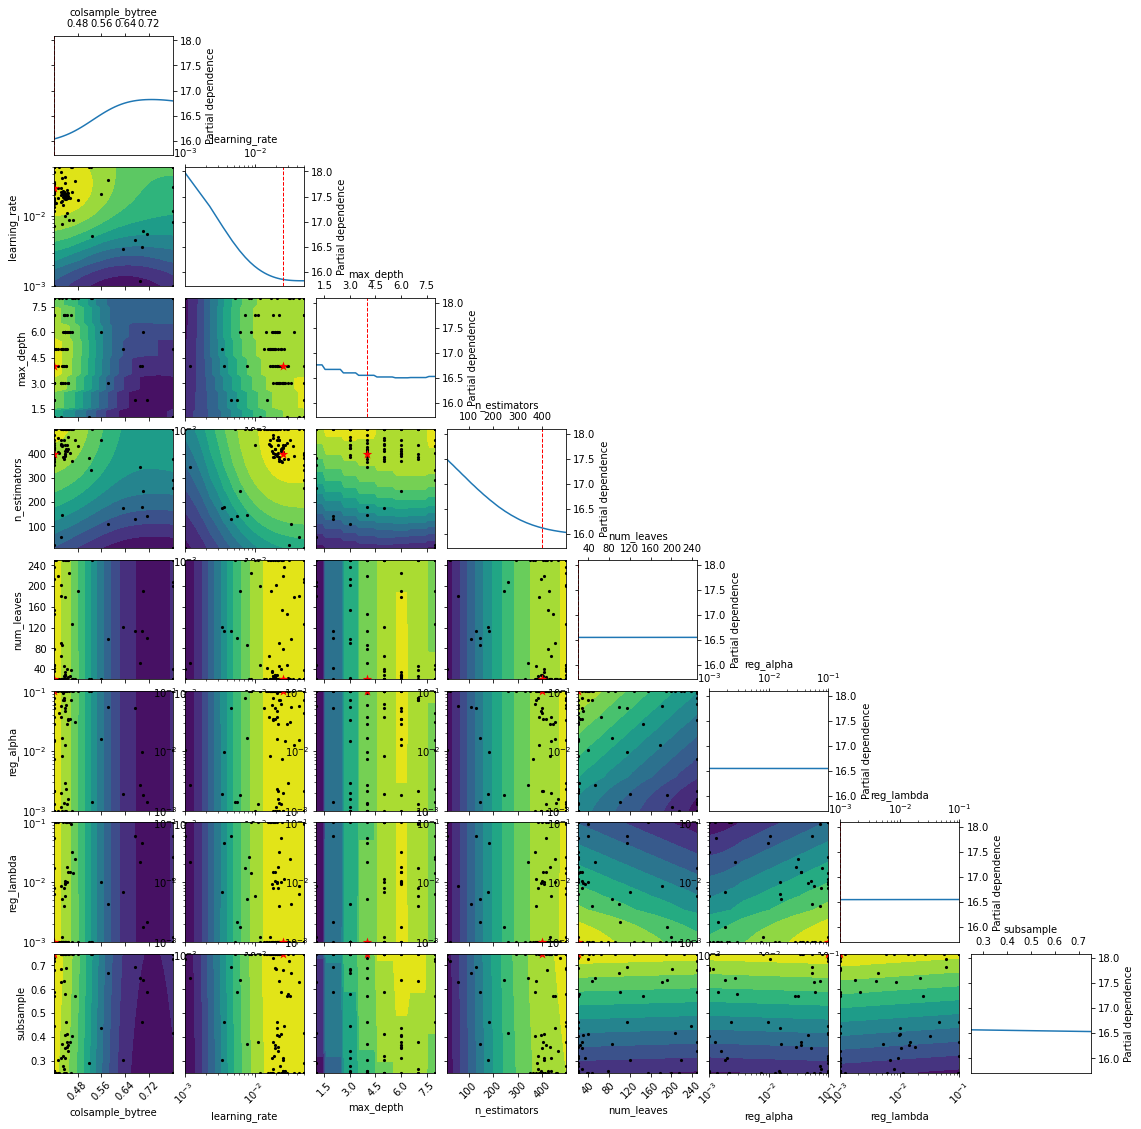

In [187]:
from skopt.plots import plot_objective

for feat in opt.optimizer_results_:
    plot_objective(feat)

In [178]:
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import warnings
warnings.filterwarnings("module")

#LGBM
#Dart not working great as a booster, using the default (gbdt)
#Learning rate should be relatively high

suic_df_cat = suic_df.copy()
suic_df_cat = suic_df_cat.drop(['country-year', 'suicides/100k pop', 'suicides_no'], axis=1)

#Necessary because values with commas can't be converted to floats
suic_df_cat[' gdp_for_year ($) ']=suic_df_cat[' gdp_for_year ($) '].str.replace(',','')

scaled_cols = ['year', 'population', 'HDI for year', ' gdp_for_year ($) ', 'gdp_per_capita ($)']
cat_cols = ['country', 'sex', 'age', 'generation']

#Normalize numerical columns
preprocess_suic = make_column_transformer(
    (StandardScaler(),scaled_cols),
    remainder='passthrough'
)


suic_df_cat_preprocessed = preprocess_suic.fit_transform(suic_df_cat)
cat_classifier = CatBoostRegressor()

params = {
    'depth': [4, 10],
    'learning_rate': [0.1, 0.01],
    'iterations': [10, 1000],
    'l2_leaf_reg': [0.01, 0.001],
}

models_in = {
    'CAT': cat_classifier
}

params_in = {
    'CAT': params
}


features = scaled_cols+cat_cols
cat_inds = np.arange(len(scaled_cols), len(features))

"""
grid_search = EstimatorSelectionHelper(models_in, params_in)
grid_search.fit_Cat(suic_df_cat_preprocessed, labels_suic, n_jobs=-1, cv=10, 
                cat_features=cat_inds,
                scoring='neg_root_mean_squared_error', verbose=False)
print(grid_search.score_summary(sort_by='mean_score'))
"""

fit_params= {
    'cat_features': cat_inds,
    'verbose': False
}


opt_Cat = BayesSearchCV(
    cat_classifier,
    {
        'depth': Integer(4, 10),
        'learning_rate': Real(0.001, 0.1, 'log-uniform'),
        'iterations': Integer(10, 500),
        'l2_leaf_reg': Real(0.0001, 0.1, 'log-uniform'),
    },
    cv=10,
    n_iter=50,
    fit_params=fit_params,
    scoring='neg_root_mean_squared_error',
    return_train_score=True,
    verbose=False,
    n_jobs=-1
)

opt_Cat.fit(suic_df_cat_preprocessed, labels_suic)
print(opt_Cat.best_score_)
print(opt_Cat.best_params_)


C:\Users\loicm\anaconda3\envs\ece219_2\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


-14.861022586206131
OrderedDict([('depth', 7), ('iterations', 431), ('l2_leaf_reg', 0.1), ('learning_rate', 0.010198758783996162)])


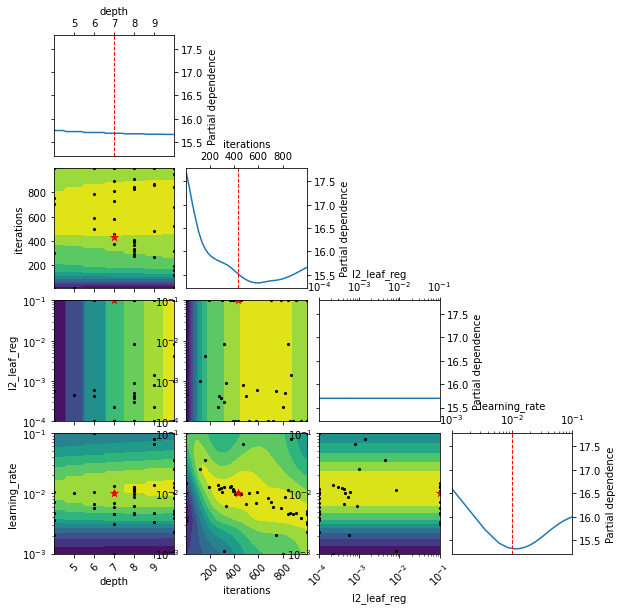

In [196]:
for feat in opt_Cat.optimizer_results_:
    plot_objective(feat)

In [180]:
#Save so we don't have to rerun
import pickle
filename_cat = 'cat_bayesian_cv.mod'
pickle.dump(opt_Cat, open(filename_cat, 'wb'))

filename_lgb = 'lgb_bayesian_cv.mod'
pickle.dump(opt, open(filename_lgb, 'wb'))

#loaded_model = pickle.load(open(filename, 'rb'))

C:\Users\loicm\anaconda3\envs\ece219_2\lib\site-packages\ipykernel_launcher.py:4: ResourceWarning: unclosed file <_io.BufferedWriter name='cat_bayesian_cv.mod'>
  after removing the cwd from sys.path.
C:\Users\loicm\anaconda3\envs\ece219_2\lib\site-packages\ipykernel_launcher.py:7: ResourceWarning: unclosed file <_io.BufferedWriter name='lgb_bayesian_cv.mod'>
  import sys


In [ ]:
#Polynomial Regression
#Q14
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score 


degrees = [2, 3, 4]
alphas = [1,.1,.01,.001]
best_score = -100000000
best_degree = 0
best_alpha = 0
for degree in degrees:
    for alpha in alphas:
        poly_features = PolynomialFeatures(degree = degree)
        suic_poly = poly_features.fit_transform(suic_data_ready)
        polynomial_regressor = Lasso(alpha=alpha,max_iter=10000)
        polynomial_regressor.fit(suic_poly, labels_suic)
        scores = cross_val_score(polynomial_regressor, suic_poly, labels_suic, cv=5, scoring='neg_root_mean_squared_error')
        if abs(min(scores)) < abs(best_score):
            best_score = min(scores)
            best_degree = degree
            best_alpha = alpha
        
print("best degree = " + str(best_degree))
print("best RMSE = " + str(best_score))
print("best alpha = " + str(best_alpha))